In [1]:
import numpy as np
import scipy.optimize
import scipy.interpolate as interp
import sys
from scipy import signal
from lmfit import minimize, Parameters
from multiprocessing import Process

#Make np arrays print in scientific notation:
np.set_printoptions(formatter={'float': lambda x: format(x, '9.4E')})
#Make numbers display in exponential form:
%precision %e
end=1

In [2]:
import matplotlib.pyplot as plt 
from matplotlib import rcParams

rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['font.family'] = 'serif' 
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.grid']=True
rcParams['axes.titlesize']=24
rcParams['axes.labelsize']=20
rcParams['axes.titlepad']=15
rcParams['legend.frameon'] = True
rcParams['legend.facecolor']='white'
rcParams['legend.fontsize']=18

# User input

In [3]:
scatter=[0.1,0.2,0.3] #scatter assumption in dex---Enter as many scatter assumptions as you want to evaluate here, separated by commas.
begbins_fromuser=8. #set the log M_* point at which the program will start evaluation
endbins_fromuser=11.4 # #set the log M_* point at which the program will end evaluation 

# Importing halo mass array from the Bolshoi simulation

In [4]:
MHALDATA = np.loadtxt ("halo_bolshoi_z0.00_D360.dat", unpack=True, usecols=1) #halo mass per 250/0.7 cubic megaparsecs

# Defining functions and bins
Hudson's $f_*(M_h)$ function<br>
Bins<br>
Baldry et. al. 2012 SMF<br>
SMF given by $f_*$<br>
Fitting function (error-weighted residuals)<br>

In [11]:
####################################################################################
#Hudson's f_*(M_h) function#########################################################
'''Defining Hudson's fstar function and  and starting the code off with some guesses
as to the parameters thereof.'''
def fstar(m_indp,m1,f1,beta,gamma,*params):
    '''Provide the option to push either a value 
    or the f1 function with associated parameters to the fstar function'''
    if callable(f1):
        f1val=f1(*params[:3])
    else:
        f1val=f1
    '''Provide the option to push either a value 
    or the m1 function with associated parameters to the fstar function'''
    if callable(m1):
        m1val=m1(*params[3:])
    else:
        m1val=m1
    
    fstar=2.*f1val*((m_indp/m1val)**-beta+(m_indp/m1val)**gamma)**-1.
    return fstar

'''Hudson allows f1, the stellar fraction at a given mass, and m1, a 
characteristic halo mass, to evolve with 
redshift, the method of which the following functions reproduce. In its current state, the program
does not actually use these functions'''
def f1(fpoint5,z,fz):
    f1=fpoint5+(z-0.5)*fz
    return f1
def m1(logmpoint5,z,mz):
    logm1=logmpoint5+(z-0.5)*mz
    m1=10.**logm1
    return m1

#Redshift
z=0

#f1 inputs
fpoint5_0=0.0414
fz_0=0.029
f1_0=0.022 #This is the value I'll use to override f1 instead of using the f1 function, when I choose to do so.

#m1 inputs
logmpoint5_0=11.04
mz_0=0.56
m1_0=10.**12. #This value will override m1 instead of using the m1 function when I choose to do so.
logm1_0=np.log10(m1_0)

#Other fstar inputs
beta_0=1.28
gamma_0=0.73

#Translating the initial guesses into a Parameters object that lmfit can use
p_chisqr=Parameters()
p_chisqr.add('logm1',value=logm1_0,vary=True,min=11.9,max=12.1)
p_chisqr.add('f1',value=f1_0,vary=True,min=0.017,max=0.025)
p_chisqr.add('beta',value=beta_0,vary=True,min=1.15,max=1.5)
p_chisqr.add('gamma',value=gamma_0,vary=True,min=0.5,max=1.)
####################################################################################

####################################################################################
#Creating bins######################################################################
LOGMSTARBINSIZE=0.05 #Bin size in units of dex
BEGBINS=begbins_fromuser
ENDBINS=endbins_fromuser
LOGMSTARBINS=np.arange(BEGBINS,ENDBINS+LOGMSTARBINSIZE,LOGMSTARBINSIZE) #M_* bins in dex (Add 1 to the num arg because the elements include the starting point.)
LOGMSTARMIDBINS=(LOGMSTARBINS[1:]+LOGMSTARBINS[:-1])/2
####################################################################################

####################################################################################
#Defining and calculating the SMF by Baldy et. al. 2012 and the associated errors###
def smf(m,m_ast,phi_ast1,phi_ast2,alpha1,alpha2):
    return np.exp(-m/m_ast)*(phi_ast1*(m/m_ast)**alpha1+phi_ast2*(m/m_ast)**alpha2)/m_ast*m

m_ast = 10.**10.66 #M* in solar mass
phi_ast1 = 3.96*10.**-3. #Mpc^-3
alpha1 = -0.35
phi_ast2 = 0.79*10.**-3. #Mpc^-3
alpha2 = -1.47

smftrue=smf(10.**LOGMSTARMIDBINS,m_ast,phi_ast1,phi_ast2,alpha1,alpha2)
logsmftrue=np.log10(smftrue)

Ntrue=smftrue*(250./0.7)**3.*LOGMSTARBINSIZE #Translating Baldry number density into Baldry number
frac_dsmftrue=1/np.sqrt(Ntrue) #Poisson fractional errors
dsmftrue=smftrue*frac_dsmftrue #calculating error on n from dn/n
dlogsmftrue=dsmftrue/(smftrue*np.log(10.)) #Propogating error to log(n)
####################################################################################

####################################################################################
#Defining a function to translate f_* into the corresponding SMF####################
'''Defining a function that will fill an array with the log number densities of log stellar-masses
given an array of log stellar masses'''

#Number density function:
def logn(p,logmstarmidbins,gaussar):
    if type(p) is Parameters:
        logm1=p['logm1'].value
        f1=p['f1'].value
        beta=p['beta'].value
        gamma=p['gamma'].value
    else:
        logm1,f1,beta,gamma=p
    
    m1=10.**logm1
    logmstarmean=np.log10(MHALDATA*fstar(MHALDATA,m1,f1,beta,gamma))
    logmstarscattered=logmstarmean+gaussar #adding the gaussian random deviate with specified standard deviation to the mean log(mstar(mhal)) array
        
    fig=plt.figure()
    ax=fig.add_subplot(111)
    N, binsout, patches = ax.hist(logmstarscattered,bins=LOGMSTARBINS,edgecolor='k',linewidth=0.2)
    plt.close() #stops the histogram from displaying
     
    n=N/(250./0.7)**3./LOGMSTARBINSIZE #number of galaxies of a given mass per cubic Megaparsec per dex (diving by bin size to make the function independent of binsize, dividing by 0.7 is dividing by h)
    logn=np.where(n==0,-9.e9,np.log10(n)) #setting n to a small finite number where it would otherwise be -infinity
    
    global i
    i+=1
    if i%100==0: print 'iteration {0:0.0f}'.format(i)
   
    return logn
####################################################################################

####################################################################################
#Fitting function###################################################################
def weightedresidsfunction(p,logmstarmidbins,gaussar,Y):
    y=logn(p,logmstarmidbins,gaussar)
    resids=y-Y
    weightedresidsar=resids/dlogsmftrue
    return weightedresidsar
####################################################################################

# Optimization
Find the parameters of the Hudson fitting function so that, given a certain scatter, the resulting stellar mass function matches Baldry.


0.1 DEX RUN


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:114: RuntimeWarning: divide by zero encountered in log10


iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800


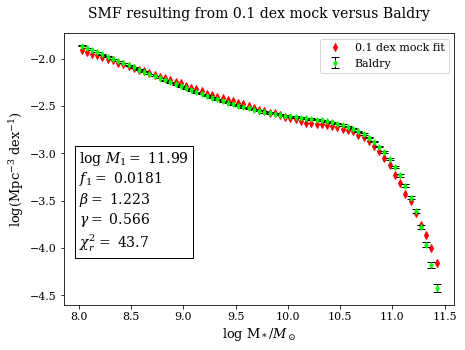


0.2 DEX RUN
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700


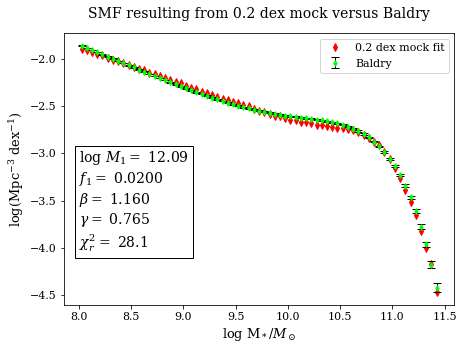


0.3 DEX RUN
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
iteration 800


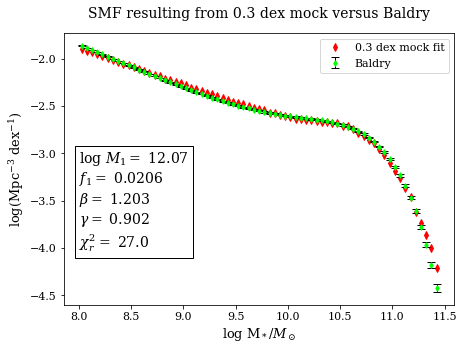

In [13]:
#create a list into which to put the best-fit parameters:
results=[]
for s in scatter:
    gaussN=MHALDATA.size
    gaussar=np.random.normal(0,s,gaussN) #Calculating an array of Guassian random deviates with mean 0 and standard deviation specified by the user in dex

    i=0 #resetting the iteration counter
    
    print'\n{0:0.1f} DEX RUN'.format(s)
    
    hudsonfit=minimize(weightedresidsfunction,p_chisqr,args=(LOGMSTARMIDBINS,gaussar,logsmftrue),
                       method='basinhopping') #Running the Chi^2 fit using basin hopping method
    results.append(hudsonfit.params)
    lognfitar=logn(hudsonfit.params,LOGMSTARMIDBINS,gaussar) #calucating the SMF resulting from filling Hudson's f_* with the optimized parameters
    lognguessar=logn(p_chisqr,LOGMSTARMIDBINS,gaussar) #calucating the SMF resulting from filling Hudson's f_* with the guessed parameters
    chisqrval=np.sum(weightedresidsfunction(hudsonfit.params,LOGMSTARMIDBINS,gaussar,logsmftrue)**2.)
    redchisqrval=chisqrval/(LOGMSTARMIDBINS.size-4.)
    
    fig=plt.figure(figsize=(7,5))
    ax=fig.add_subplot(1,1,1)
    #ax.plot(LOGMSTARMIDBINS,lognguessar,'bd',label='0.2 dex mock guess',ms=5)
    ax.plot(LOGMSTARMIDBINS,lognfitar,'rd',label='{0:0.1f} dex mock fit'.format(s),ms=5)
    truecol=(0.,255./255.,0./255.)
    ax.errorbar(LOGMSTARMIDBINS,logsmftrue,dlogsmftrue,fmt='d',mfc=truecol,mec=truecol,capsize=4,ecolor='k', elinewidth=1,ms=4,label='Baldry')
    ax.grid()
    ax.legend(fontsize=11)
    ax.set_title('SMF resulting from {0:0.1f} dex mock versus Baldry'.format(s),fontsize=14)
    ax.set_ylabel('log(Mpc$^{-3}$ dex$^{-1}$)',fontsize=13)
    ax.set_xlabel('log M$_*/M_\odot$',fontsize=13)
    bbox_props=dict(boxstyle='square',fc='white') #Define properties of text box
    ax.text(8,-4,'log $M_1=$ {0:0.2f}'
            '\n$f_1=$ {1:0.4f}'
            '\n$\\beta=$ {2:0.3f}'
            '\n$\gamma=$ {3:0.3}'
            '\n$\\chi^2_r=$ {4:0.1f}'.format(hudsonfit.params['logm1'].value,
                                         hudsonfit.params['f1'].value,
                                         hudsonfit.params['beta'].value,
                                         hudsonfit.params['gamma'].value,
                                         redchisqrval),
           fontsize=14,bbox=bbox_props)
    ax.tick_params(axis='both',labelsize=11)
    plt.show()

# Using Bolshoi halo masses
The following cell populates $f_*$ with the halo masses that appear in the Bolshoi simulation.

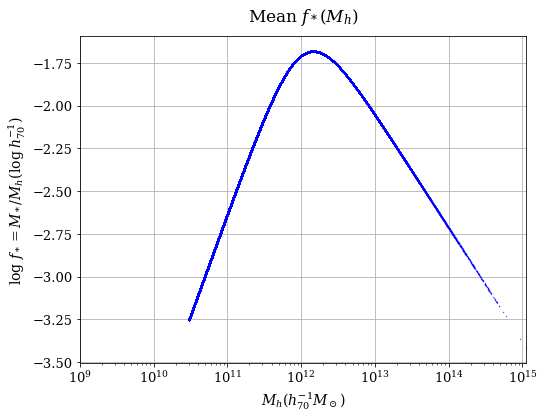

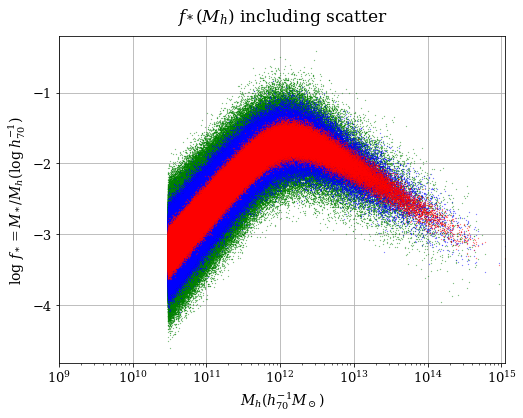

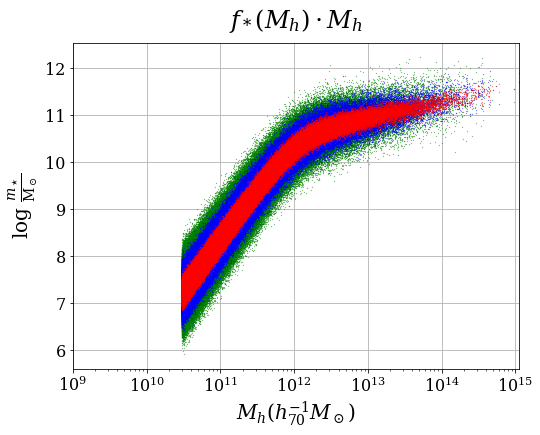

In [7]:
#Hudson function parameters found for 0.2 dex scatter:
m1_2=10.**12.03
f1_2=0.02
beta_2=1.197
gamma_2=0.668

#The next, currently commented line uses a forced value for m1 and 
#the functional form of f1
#fstarofmhal=fstar(MHALDATA,m1_0,f1,beta_0,gamma_0,fpoint5_0,z,fz_0)

#The following line forces values into m1 and f1 as opposed to using the 
#m1 and f2 functions with associated parameters
fstarofmhal=fstar(MHALDATA,m1_2,f1_2,beta_2,gamma_2)

logfstarofmhal=np.log10(fstarofmhal) #Put f_*(M_h) in log

#Adding different scatters to log f_*
GAUSSN=MHALDATA.size
GAUSS1=np.random.normal(0,0.1,GAUSSN) #create an array of Gaussian random deviates with std dev 0.1
GAUSS2=np.random.normal(0,0.2,GAUSSN) #create an array of Gaussian random deviates with std dev 0.2
GAUSS3=np.random.normal(0,0.3,GAUSSN) #create an array of Gaussian random deviates with std dev 0.3
GAUSS4=np.random.normal(0,0.4,GAUSSN) #create an array of Gaussian random deviates with std dev 0.4
logfstarofmhalprime1=GAUSS1+logfstarofmhal 
logfstarofmhalprime2=GAUSS2+logfstarofmhal 
logfstarofmhalprime3=GAUSS3+logfstarofmhal 

#Defining M_* based on Bolshoi halo masses, as distinct from f_*(M_*/M_h)
logmstarofmhalprime1=logfstarofmhalprime1+np.log10(MHALDATA)
logmstarofmhalprime2=logfstarofmhalprime2+np.log10(MHALDATA)
logmstarofmhalprime3=logfstarofmhalprime3+np.log10(MHALDATA)

#Plotting Hudson's f_* using Bolshoi halo masses############################
plotbase=10 #The plots below will use a log scale for their y axes with base plotbase
xmin=10.**9.
xmax=max(MHALDATA)

fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)
ax.semilogx(MHALDATA,logfstarofmhal,'bo',markersize=0.3)
ax.set_xlim(xmin,xmax)
ax.set_title('Mean $f_*(M_h)$',fontsize=17)
ax.set_ylabel('log $f_*=M_*/M_h(\log\;h^{-1}_{70})$',fontsize=14)
ax.set_xlabel('$M_h(h_{70}^{-1}M_\odot)$',fontsize=14)
ax.tick_params(axis='both',labelsize=13)
ax.grid(True)
plt.show()
############################################################################

#Plotting Hudson's f_* using Bolshoi halo masses with scatter added#########
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)
ax.semilogx(MHALDATA,logfstarofmhalprime3,'go',markersize=0.2)
ax.semilogx(MHALDATA,logfstarofmhalprime2,'bo',markersize=0.2)
ax.semilogx(MHALDATA,logfstarofmhalprime1,'ro',markersize=0.2)
ax.set_xlim(xmin,xmax)
ax.set_title('$f_*(M_h)$ including scatter',fontsize=17)
ax.set_ylabel('log $f_*=M_*/M_h(\log\;h^{-1}_{70})$',fontsize=14)
ax.set_xlabel('$M_h(h_{70}^{-1}M_\odot)$',fontsize=14)
ax.tick_params(axis='both',labelsize=13)
ax.grid(True)
plt.show()
############################################################################

#Showing just M_* based on Bolshoi masses, not M_*/M_h######################
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)
ax.semilogx(MHALDATA,logmstarofmhalprime3,'go',markersize=0.2)
ax.semilogx(MHALDATA,logmstarofmhalprime2,'bo',markersize=0.2)
ax.semilogx(MHALDATA,logmstarofmhalprime1,'ro',markersize=0.2)
ax.set_xlim(xmin,xmax)
ax.set_title('$f_*(M_h)\cdot M_h$')
ax.set_ylabel('log $\\frac{m_\star}{\mathrm{M}_\odot}$')
ax.set_xlabel('$M_h(h_{70}^{-1}M_\odot)$')
ax.tick_params(axis='both')
plt.show()
############################################################################

## Making plots for phys443 paper

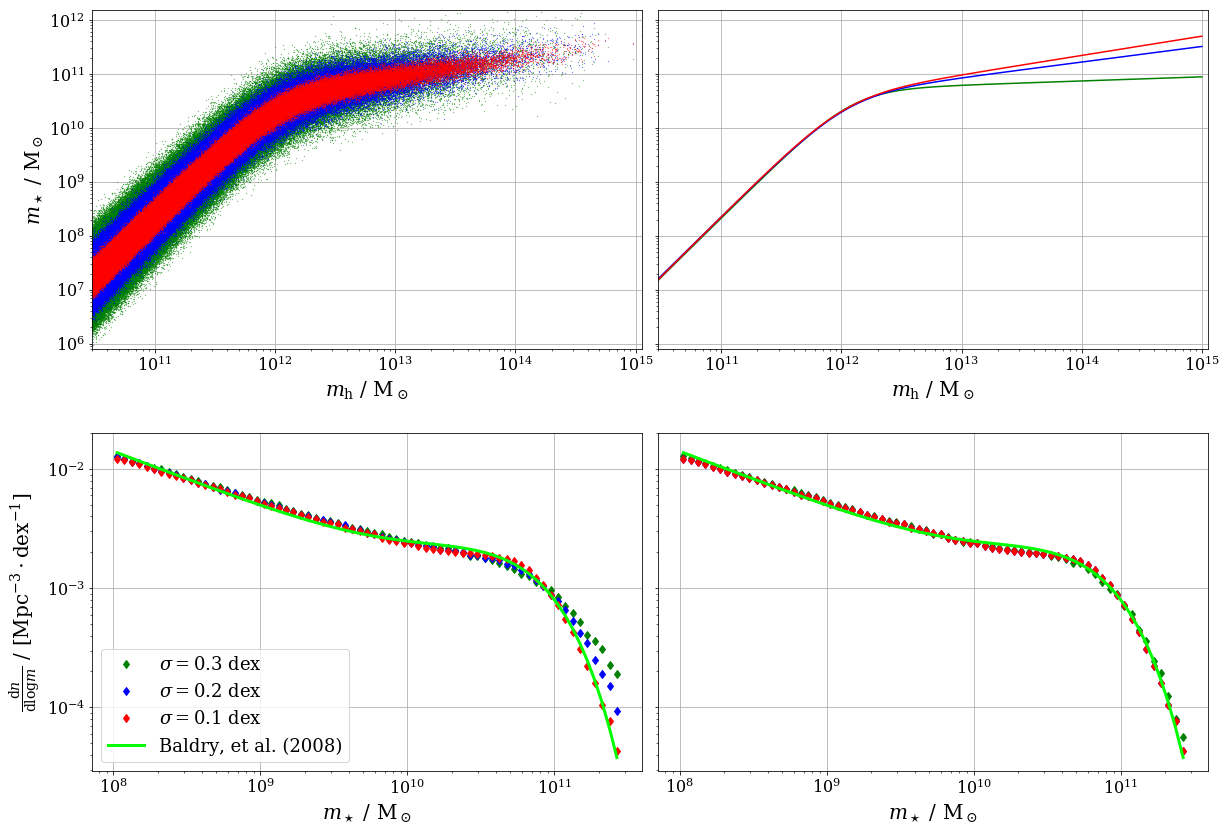

In [12]:
fig=plt.figure(figsize=(20,14))

fit_ylim=[10.**logmstarofmhalprime3.min(),1.5e12]
fit_xlim=[MHALDATA.min(),xmax]
smf_ylim=[2.9e-5,2e-2]

#Showing just M_* based on Bolshoi masses, not M_*/M_h###########################
ax1=fig.add_subplot(2,2,1)
ax1.semilogx(MHALDATA,10.**logmstarofmhalprime3,'go',markersize=0.2)
ax1.semilogx(MHALDATA,10.**logmstarofmhalprime2,'bo',markersize=0.2)
ax1.semilogx(MHALDATA,10.**logmstarofmhalprime1,'ro',markersize=0.2)
ax1.set_xlim(fit_xlim[0],fit_xlim[1])
ax1.set_ylim(fit_ylim[0],fit_ylim[1])
ax1.set_ylabel('$m_\star\ /\ \mathrm{M}_\odot$')
ax1.set_xlabel('$m_\mathrm{h}\ /\ \mathrm{M}_\odot$')
ax1.set_yscale('log')
ax1.tick_params(axis='both')
#################################################################################

#Plotting the fitting functions with each adjusted for the corresponding scatter#
def mgals_fit(ri,mhals):
    logm1=results[ri]['logm1'].value
    f1=results[ri]['f1'].value
    beta=results[ri]['beta'].value
    gamma=results[ri]['gamma'].value
    mgals=fstar(mhals,10.**logm1,f1,beta,gamma)*mhals
    return mgals
    
mhals=np.logspace(np.log10(3.e10),15,100)
ax2=fig.add_subplot(2,2,2)
ax2.plot(mhals,mgals_fit(2,mhals),'g')
ax2.plot(mhals,mgals_fit(1,mhals),'b')
ax2.plot(mhals,mgals_fit(0,mhals),'r')
ax2.set_xlim(fit_xlim[0],fit_xlim[1])
ax2.set_ylim(fit_ylim[0],fit_ylim[1])
ax2.set_xlabel('$m_\mathrm{h}\ /\ \mathrm{M}_\odot$')
ax2.set_xscale('log')
ax2.set_yscale('log')
#################################################################################

#Plotting the SMFsresulting from the unadjusted fitting functions################
logns_1=logn(results[0],LOGMSTARMIDBINS,GAUSS1)
logns_2=logn(results[0],LOGMSTARMIDBINS,GAUSS2)
logns_3=logn(results[0],LOGMSTARMIDBINS,GAUSS3)
ax3=fig.add_subplot(2,2,3)
ax3.plot(10.**LOGMSTARMIDBINS,10.**logns_3,'gd',label='$\sigma=0.3$ dex')
ax3.plot(10.**LOGMSTARMIDBINS,10.**logns_2,'bd',label='$\sigma=0.2$ dex')
ax3.plot(10.**LOGMSTARMIDBINS,10.**logns_1,'rd',label='$\sigma=0.1$ dex')
gcol=(0.,255./255.,0./255.)
ax3.plot(10.**LOGMSTARMIDBINS,10.**logsmftrue,color=gcol,lw=3,
        label='Baldry, et al. (2008)')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylabel('$\\frac{\mathrm{d}n}{\mathrm{dlog}m}$ / [Mpc$^{-3}\cdot$dex$^{-1}$]')
ax3.set_xlabel('$m_\star$ / M$_\odot$')
ax3.set_ylim(smf_ylim[0],smf_ylim[1])
ax3.legend()
#################################################################################

#Plotting the SMFs using the correct fitting functions###########################
logns_2=logn(results[0],LOGMSTARMIDBINS,GAUSS1)
logns_3=logn(results[1],LOGMSTARMIDBINS,GAUSS2)
logns_4=logn(results[2],LOGMSTARMIDBINS,GAUSS3)
ax4=fig.add_subplot(2,2,4)
ax4.plot(10.**LOGMSTARMIDBINS,10.**logns_3,'gd')
ax4.plot(10.**LOGMSTARMIDBINS,10.**logns_2,'bd')
ax4.plot(10.**LOGMSTARMIDBINS,10.**logns_1,'rd')
gcol=(0.,255./255.,0./255.)
ax4.plot(10.**LOGMSTARMIDBINS,10.**logsmftrue,color=gcol,lw=3)
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.set_ylim(smf_ylim[0],smf_ylim[1])
#ax4.set_ylabel('$\\frac{\mathrm{d}n}{\mathrm{dlog}m}$ / [Mpc$^{-3}\cdot$dex$^{-1}$]')
ax4.set_xlabel('$m_\star$ / M$_\odot$')
#################################################################################

fig.subplots_adjust(wspace=0.03,hspace=0.25)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.show()

# Manually finding parameters based on $\chi^2_r$

iteration 900
iteration 1000
iteration 1100
iteration 1200
iteration 1300
iteration 1400
iteration 1500


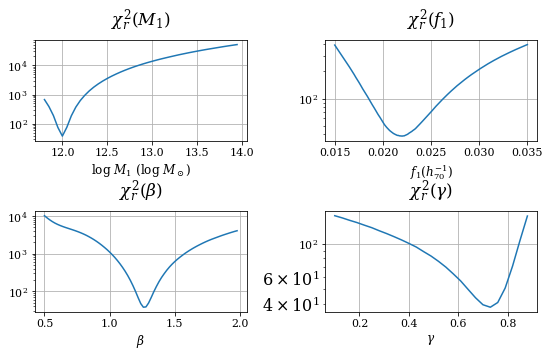

In [14]:
#Calculating the data###############################################################
logm1range=np.arange(11.8,14.,0.05)
redchisqroflogm1=np.array([])
for m in logm1range:
    p_redchisqr=[m,f1_0,beta_0,gamma_0]
    resids=logn(p_redchisqr,LOGMSTARMIDBINS,GAUSS2)-logsmftrue
    wresids=weightedresidsfunction(p_redchisqr,LOGMSTARMIDBINS,GAUSS2,logsmftrue)
    #chisqroflogm1=np.sum((resids/dlogn2ar)**2.)
    chisqroflogm1=np.sum(wresids**2.)
    redchisqroflogm1=np.append(redchisqroflogm1,chisqroflogm1/(LOGMSTARMIDBINS.size-2.))
    
f1range=np.arange(0.015,3.5e-2,0.1e-3)
redchisqroff1=np.array([])
for f in f1range:
    p_redchisqr=[logm1_0,f,beta_0,gamma_0]
    resids=logn(p_redchisqr,LOGMSTARMIDBINS,GAUSS2)-logsmftrue
    #chisqroff1=np.sum((resids/dlogn2ar)**2.)
    wresids=weightedresidsfunction(p_redchisqr,LOGMSTARMIDBINS,GAUSS2,logsmftrue)
    chisqroff1=np.sum(wresids**2.)
    redchisqroff1=np.append(redchisqroff1,chisqroff1/(LOGMSTARMIDBINS.size-2.))
    
betarange=np.arange(0.5,2.0,0.02)
redchisqrofbeta=np.array([])
for b in betarange:
    p_redchisqr=[logm1_0,f1_0,b,gamma_0]
    resids=logn(p_redchisqr,LOGMSTARMIDBINS,GAUSS2)-logsmftrue
    #chisqrofbeta=np.sum((resids/dlogn2ar)**2.)
    wresids=weightedresidsfunction(p_redchisqr,LOGMSTARMIDBINS,GAUSS2,logsmftrue)
    chisqrofbeta=np.sum(wresids**2.)
    redchisqrofbeta=np.append(redchisqrofbeta,chisqrofbeta/(LOGMSTARMIDBINS.size-2.))
    
gammarange=np.arange(0.1,0.9,0.03)
redchisqrofgamma=np.array([])
for g in gammarange:
    p_redchisqr=[logm1_0,f1_0,beta_0,g]
    resids=logn(p_redchisqr,LOGMSTARMIDBINS,GAUSS2)-logsmftrue
    #chisqrofgamma=np.sum((resids/dlogn2ar)**2.)
    wresids=weightedresidsfunction(p_redchisqr,LOGMSTARMIDBINS,GAUSS2,logsmftrue)
    chisqrofgamma=np.sum(wresids**2.)
    redchisqrofgamma=np.append(redchisqrofgamma,chisqrofgamma/(LOGMSTARMIDBINS.size-2.))
####################################################################################

#Plotting the results###############################################################
fig=plt.figure(figsize=(9,5))
plt.subplots_adjust(wspace = 0.37,hspace=0.7)
xlabelsize=12
ticklabelsize=11

ax1=fig.add_subplot(2,2,1)
ax1.semilogy(logm1range,redchisqroflogm1)
ax1.set_xlabel('log $M_1$ (log $M_\odot$)',fontsize=xlabelsize)
ax1.set_title('$\chi^2_r(M_1)$',fontsize=17)
ax1.tick_params(axis='both',labelsize=ticklabelsize)

ax2=fig.add_subplot(2,2,2)
ax2.semilogy(f1range,redchisqroff1)
ax2.set_xlabel('$f_1 (h_{70}^{-1})$',fontsize=xlabelsize)
ax2.set_title('$\chi^2_r(f_1)$',fontsize=17)
ax2.tick_params(axis='both',labelsize=ticklabelsize)

ax2=fig.add_subplot(2,2,3)
ax2.semilogy(betarange,redchisqrofbeta)
ax2.set_xlabel('$\\beta$',fontsize=xlabelsize)
ax2.set_title('$\chi^2_r(\\beta)$',fontsize=17)
ax2.tick_params(axis='both',labelsize=ticklabelsize)

ax2=fig.add_subplot(2,2,4)
ax2.semilogy(gammarange,redchisqrofgamma)
ax2.set_xlabel('$\\gamma$',fontsize=xlabelsize)
ax2.set_title('$\chi^2_r(\\gamma)$',fontsize=17)
ax2.tick_params(axis='both',labelsize=ticklabelsize)

plt.show()
####################################################################################